In [1]:
%matplotlib inline

In [2]:
import os
import glob

import numpy as np
import pylab as plt

import astra
import tomopy
# import cv2
from pprint import pprint
import h5py

import astra

In [3]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [4]:
def build_reconstruction_geomety(detector_size, angles):
    proj_geom = astra.create_proj_geom('parallel', 1.0, detector_size, angles)
    return proj_geom

def astra_tomo2d(sinogram, angles):
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = sinogram.shape[1]
    
    rec_size = detector_size# size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['option'] = {}
#     cfg['option']['ShortScan'] = True
#     cfg['option']['MinConstraint'] = 0
#     cfg['option']['MaxConstraint'] = 0.02

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 1)
    # Get the result
    rec = astra.data2d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec, proj_geom, cfg

def astra_build_sinogram(rec, angles):
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = rec.shape[1]
    
    rec_size = detector_size# size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    proj_id = astra.create_projector('cuda',proj_geom,vol_geom)
    sinogram_id, sinogram = astra.create_sino(rec, proj_id)
    
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return sinogram

In [5]:
from tomopy.misc.phantom import shepp2d

In [24]:
data = np.squeeze(shepp2d()).astype('float32')
data/=data.max()

In [25]:
data.shape

(512, 512)

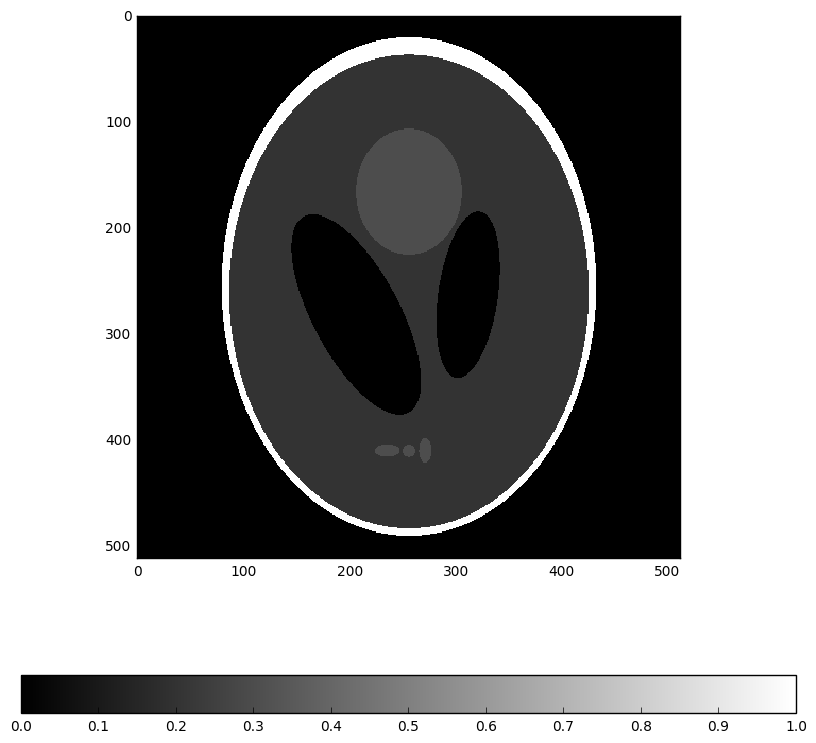

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.show()

In [113]:
angles = np.arange(0,180,0.1)*np.pi/180

In [114]:
sinogram = astra_build_sinogram(data, angles)

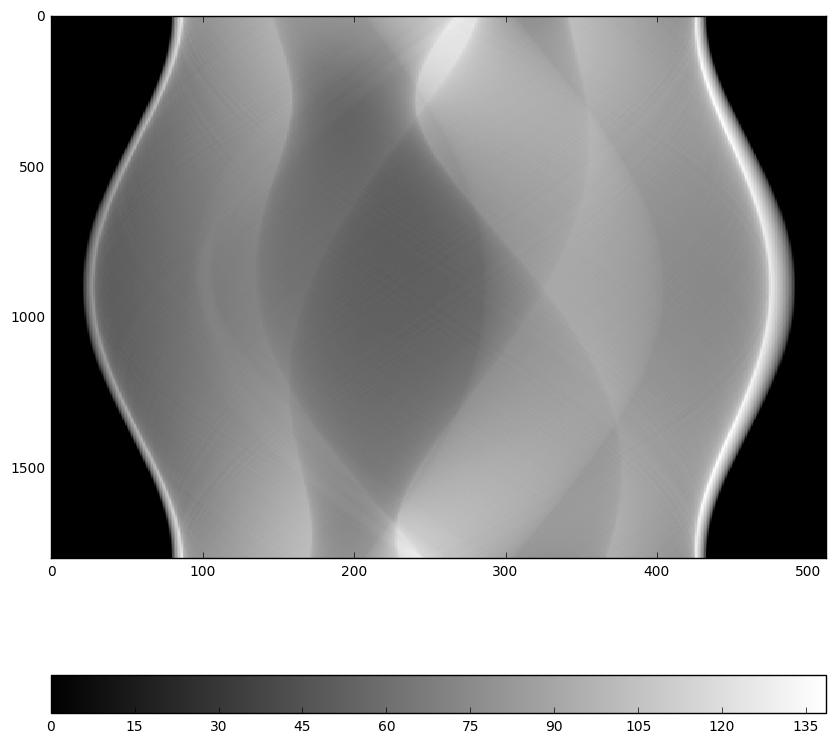

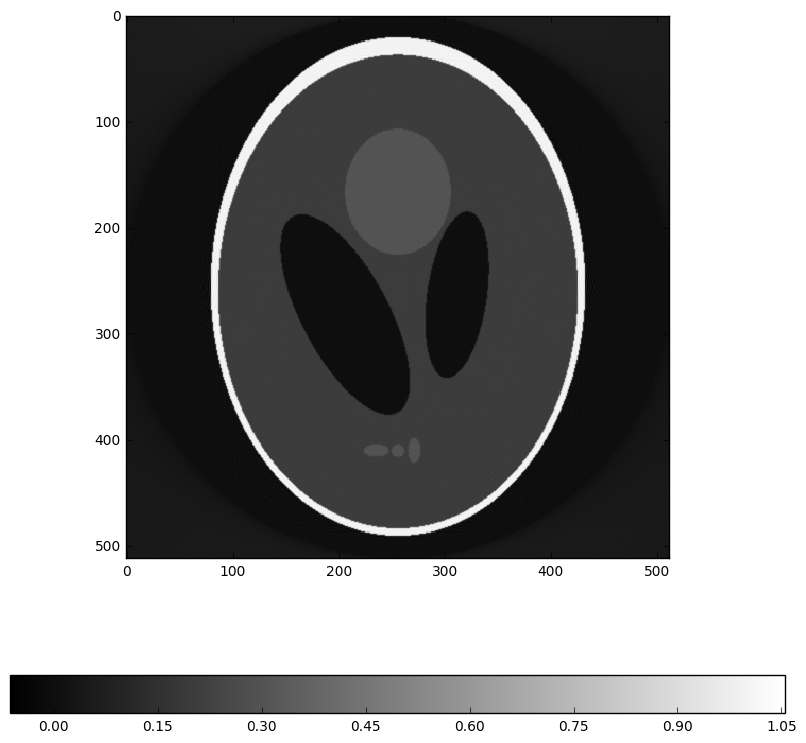

In [115]:
plt.figure(figsize=(10,10))
plt.imshow(sinogram, cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.axis('tight')
plt.show()

rec, proj_geom, cfg = astra_tomo2d(sinogram, angles)

plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec, interpolation='nearest', cmap=plt.cm.gray)
plt.colorbar(orientation='horizontal')
plt.show()

In [116]:
s_pad = 150
sinogram_cut = sinogram[:,s_pad:-s_pad]

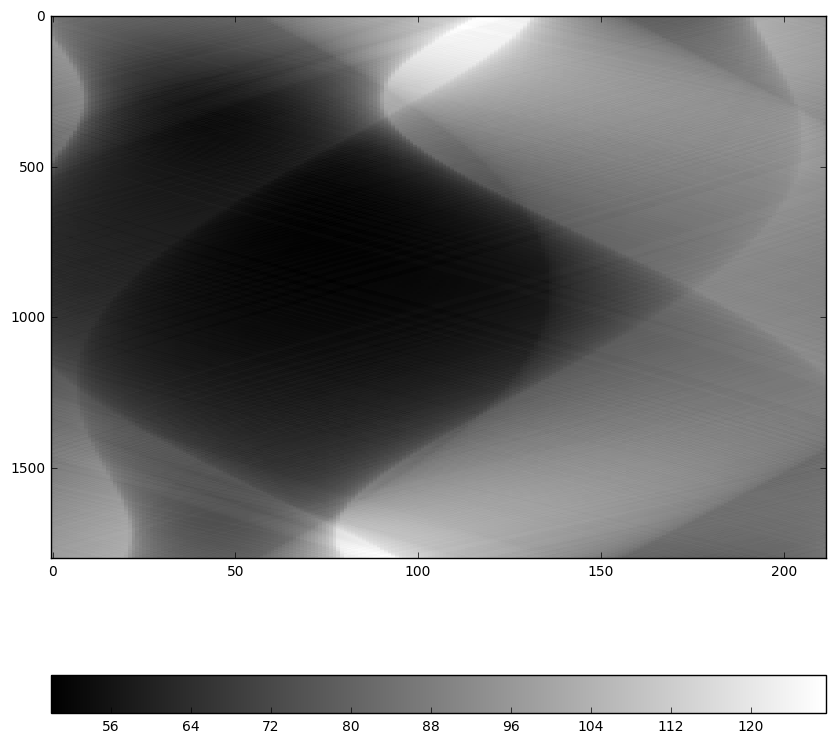

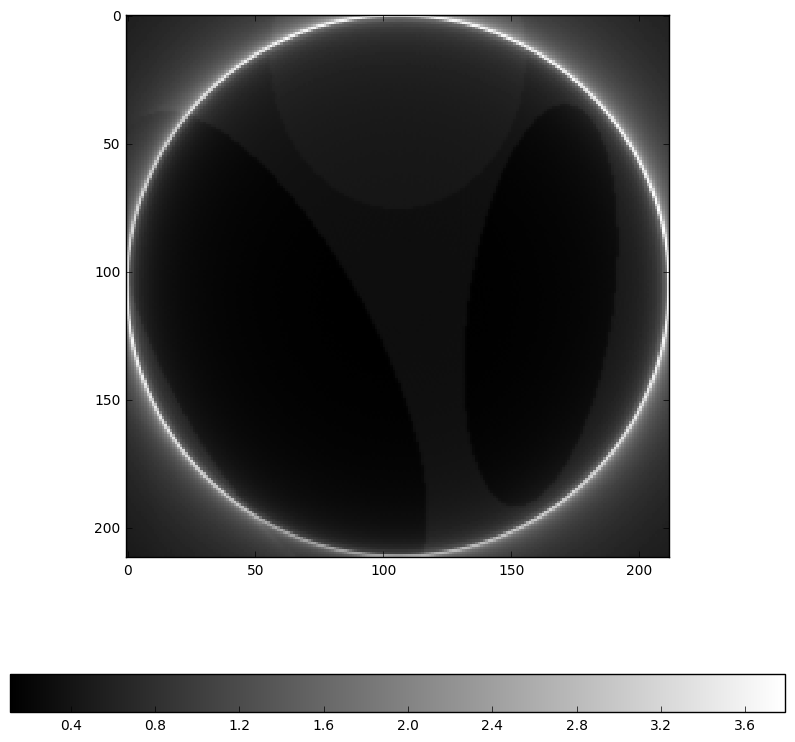

In [117]:
plt.figure(figsize=(10,10))
plt.imshow(sinogram_cut, cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.axis('tight')
plt.show()

rec_cut, proj_geom, cfg = astra_tomo2d(sinogram_cut, angles)

plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_cut, interpolation='nearest', cmap=plt.cm.gray)
plt.colorbar(orientation='horizontal')
plt.show()

In [118]:
padsize = s_pad*2

sinogram_padded = np.zeros((sinogram_cut.shape[0],sinogram_cut.shape[1]+padsize*2), dtype='float32')
sinogram_padded[:,padsize:-padsize] = sinogram_cut
rec_pad0, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)

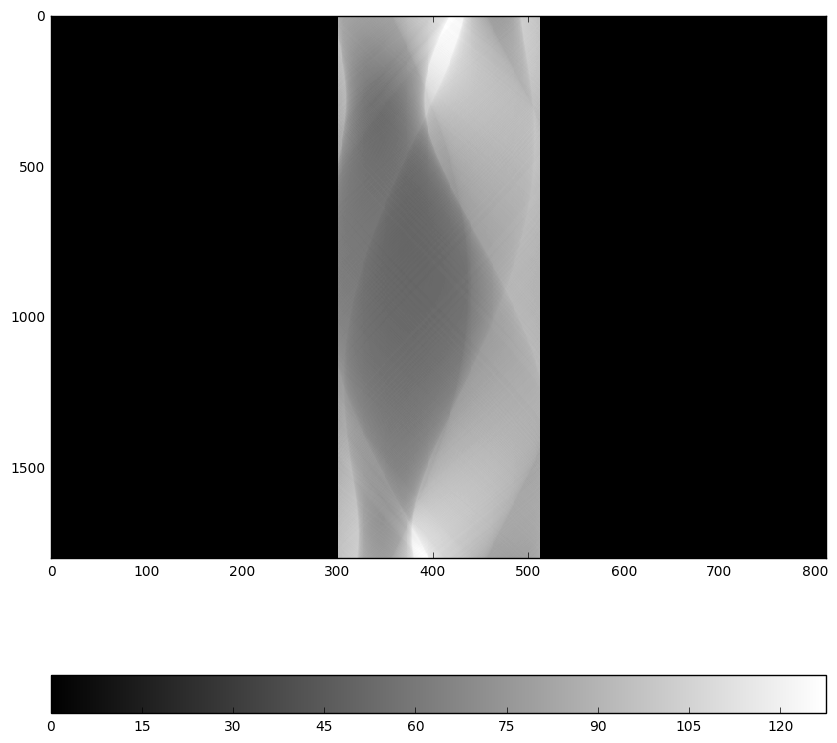

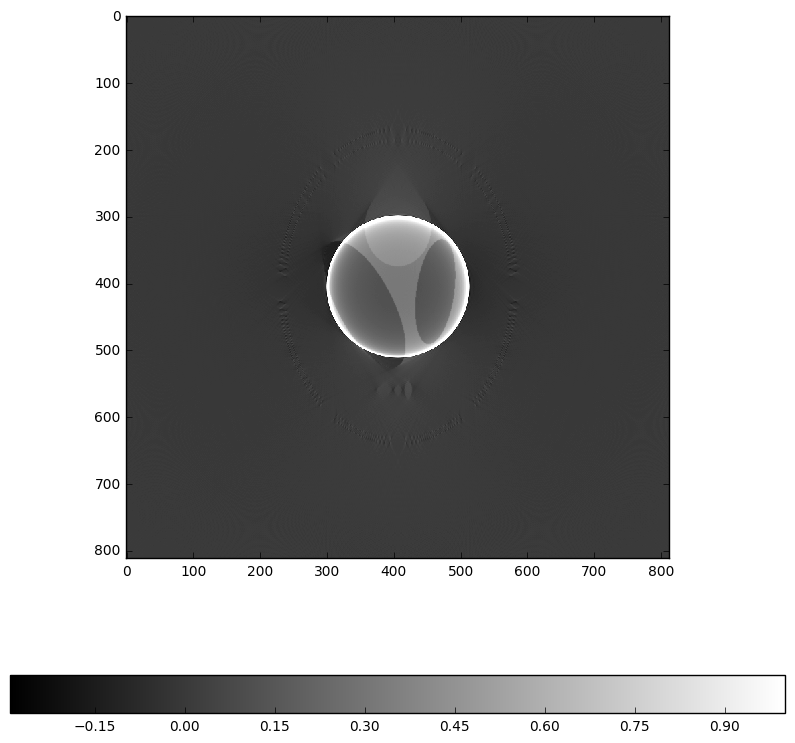

In [119]:
plt.figure(figsize=(10,10))
plt.imshow(sinogram_padded, cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.axis('tight')
plt.show()

plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_pad0, interpolation='nearest', cmap=plt.cm.gray, vmax=1)
plt.colorbar(orientation='horizontal')
plt.show()

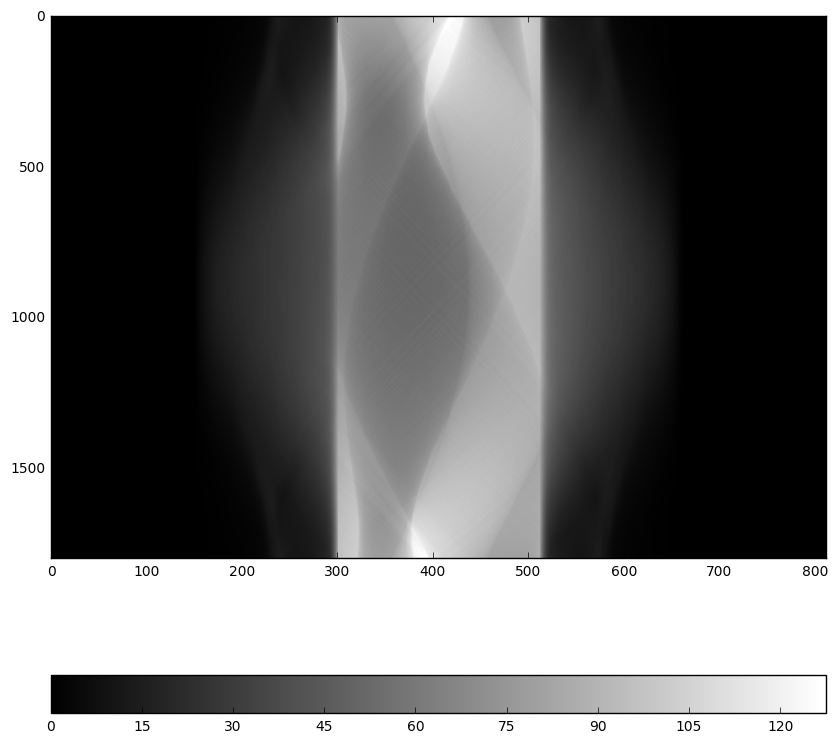

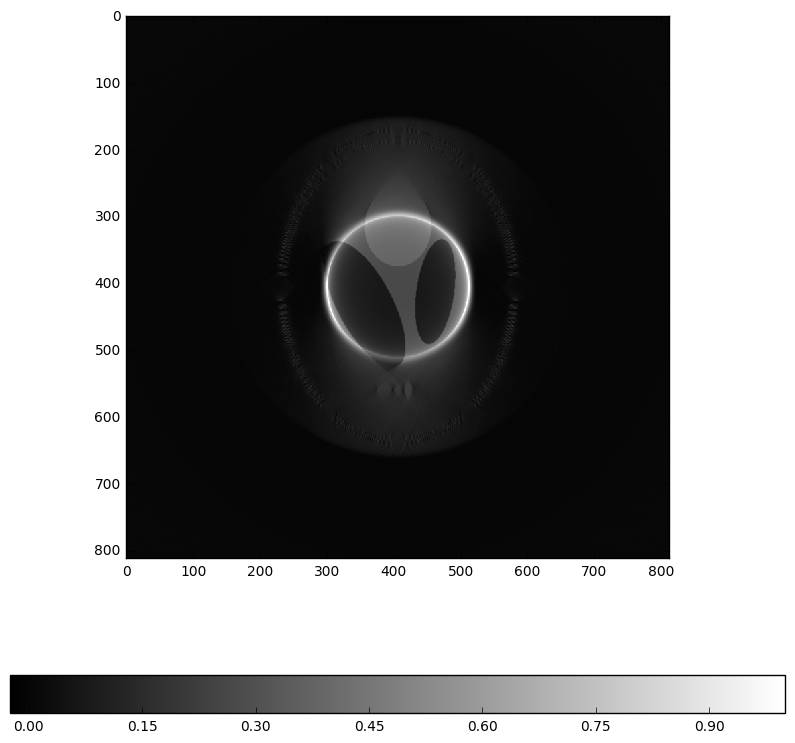

In [133]:

rec_pad, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)
sino = astra_build_sinogram(rec_pad, angles)
sino[:,padsize:-padsize] = sinogram_cut

MU = rec.sum()*2
X,Y = np.meshgrid(np.arange(rec_pad.shape[0]),np.arange(rec_pad.shape[1]))

X-=rec_pad.shape[0]//2
Y-=rec_pad.shape[1]//2

mask = (X**2+Y**2)<(rec.shape[0]//2)**2-10

for i in log_progress(range(100)):
    rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)
    
    rec_pad*=rec_pad>0
    rec_pad*=mask
    rec_pad[rec_pad>1] = 1
#     if rec_pad.sum()>MU:
#         rec_pad = rec_pad/rec_pad.sum()*MU
    sino = astra_build_sinogram(rec_pad, angles)
    sino[:,padsize:-padsize] = sinogram_cut

    

    
rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)

plt.figure(figsize=(10,10))
plt.imshow(sino, cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.axis('tight')
plt.show()

plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_pad, interpolation='nearest', cmap=plt.cm.gray,vmax=1)
plt.colorbar(orientation='horizontal')
plt.show()

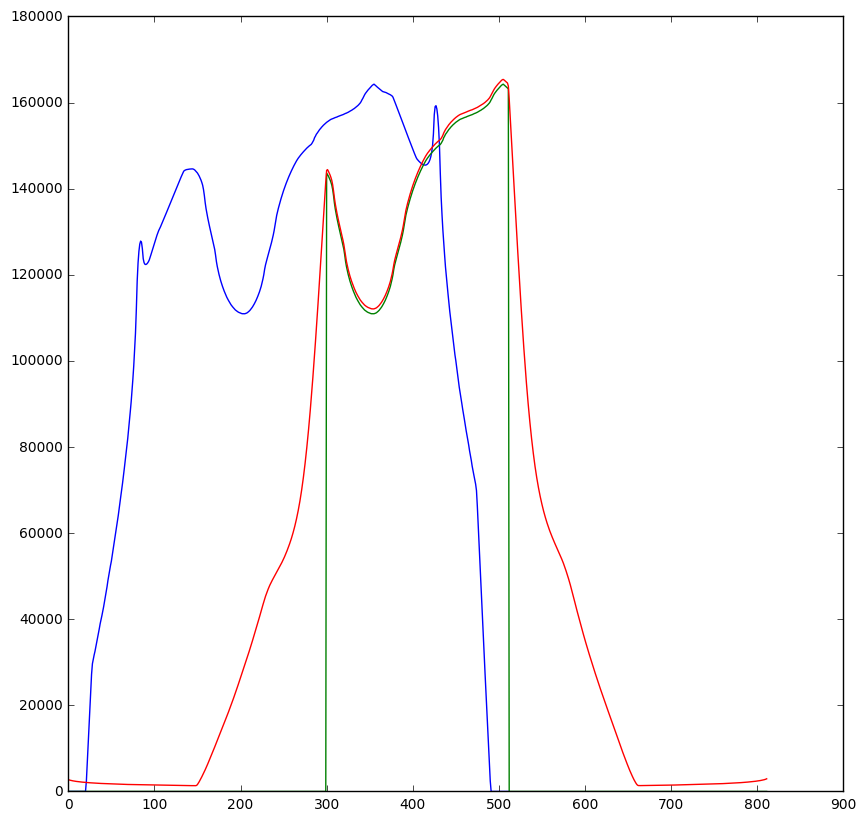

In [127]:
plt.figure(figsize=(10,10))
plt.plot(sinogram.sum(axis=0))
plt.plot(sinogram_padded.sum(axis=0))
plt.plot(sino.sum(axis=0))
plt.show()

In [123]:
sino = astra_build_sinogram(rec_pad, angles)